**Optimization Function**

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def optimize_portfolio_weights(
    tickers,
    cov_matrix,
    current_weights,
    rf_annual,
    erp_annual,
    betas
):
    # Convert to numpy array
    w0 = np.array([current_weights[t] for t in tickers])
    
    # Convert annual to quarterly
    rf_q = rf_annual / 4
    erp_q = erp_annual / 4
    
    # CAPM Expected Returns (quarterly)
    mu = np.array([rf_q + betas[t] * erp_q for t in tickers])

    # Bounds: no more than ±5% change from current weight
    bounds = [(max(0, w - 0.05), min(1, w + 0.05)) for w in w0]
    
    # Sharpe Ratio Objective (negative for minimization)
    def neg_sharpe(w, mu, cov, rf):
        port_return = np.dot(w, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        return -(port_return - rf) / port_vol
    
    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Optimization
    result = minimize(
        neg_sharpe,
        w0,
        args=(mu, cov_matrix, rf_q),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    optimized = pd.Series(result.x, index=tickers)
    current = pd.Series(current_weights)
    
    comparison = pd.DataFrame({
        "Current Weight": current,
        "Optimized Weight": optimized,
        "Difference": optimized - current
    })
    
    return optimized, comparison, mu, cov_matrix

**Set Parameters**

In [6]:
current_weights = {
    "XLK": 0.2934,
    "XLF": 0.1463,
    "XLV": 0.1103,
    "XLY": 0.1017,
    "XLC": 0.0923,
    "XLI": 0.0861,
    "XLP": 0.0657,
    "XLE": 0.0339,
    "XLU": 0.0266,
    "XLRE": 0.0233,
    "XLB": 0.0204,
}

fixed_betas = {
    "XLB": 1.16,
    "XLC": 1.12,
    "XLE": 0.84,
    "XLF": 1.08,
    "XLI": 1.12,
    "XLK": 1.23,
    "XLP": 0.56,
    "XLRE": 1.12,
    "XLU": 0.70,
    "XLV": 0.62,
    "XLY": 1.31,
}

etf_returns = pd.read_csv("etf_quarterly_returns.csv", index_col=0, parse_dates=True)
tickers = list(current_weights.keys())
cov_matrix = etf_returns[tickers].cov().values
treasury_10_yr = 0.04397
erp = 0.0433



**Run optimization**


In [10]:
# Run optimization
opt_weights, comparison_df, expected_return, covariance_matrix = optimize_portfolio_weights(
    tickers=tickers,
    cov_matrix=cov_matrix,
    current_weights=current_weights,
    rf_annual=treasury_10_yr,
    erp_annual=erp,
    betas=fixed_betas
)

print(comparison_df.map(lambda x: f"{x:.2%}"))
print(f"Expected Return: {expected_return}")

     Current Weight Optimized Weight Difference
XLK          29.34%           24.34%     -5.00%
XLF          14.63%           19.63%      5.00%
XLV          11.03%            6.03%     -5.00%
XLY          10.17%           15.17%      5.00%
XLC           9.23%            7.64%     -1.59%
XLI           8.61%            3.61%     -5.00%
XLP           6.57%            1.59%     -4.98%
XLE           3.39%            0.00%     -3.39%
XLU           2.66%            7.66%      5.00%
XLRE          2.33%            7.33%      5.00%
XLB           2.04%            7.00%      4.96%
Expected Return: [0.02430725 0.0226835  0.017704   0.02517325 0.0231165  0.0231165
 0.0170545  0.0200855  0.01857    0.0231165  0.0235495 ]


**Visualize COV Matrix**

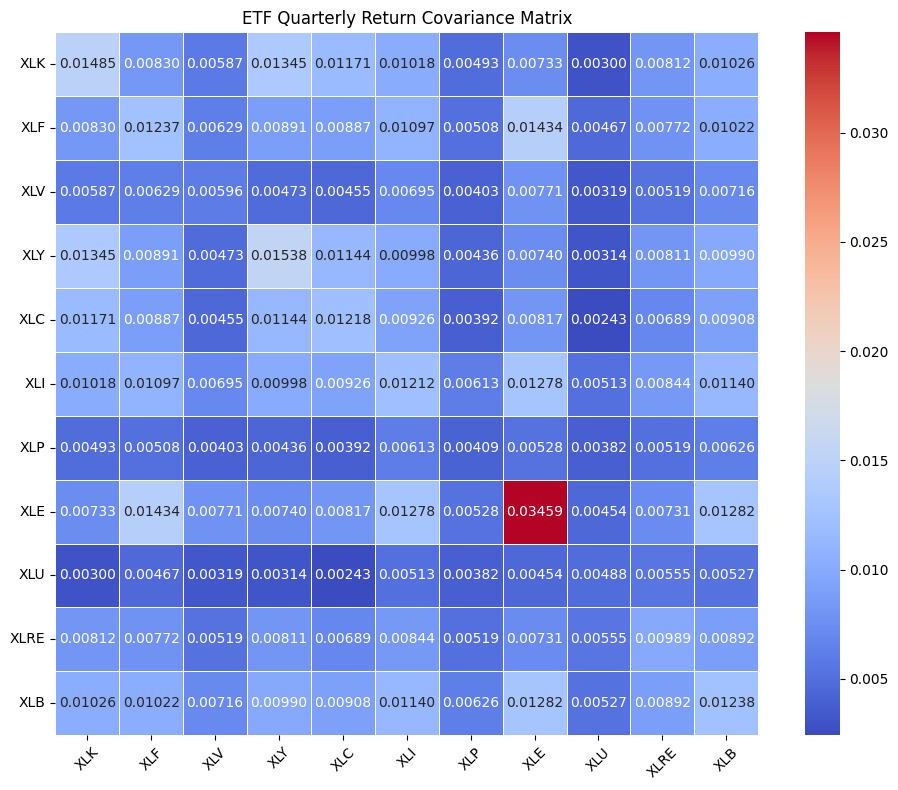

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for the covariance matrix
cov_df = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_df, annot=True, fmt=".5f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("ETF Quarterly Return Covariance Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Visualize Weights**

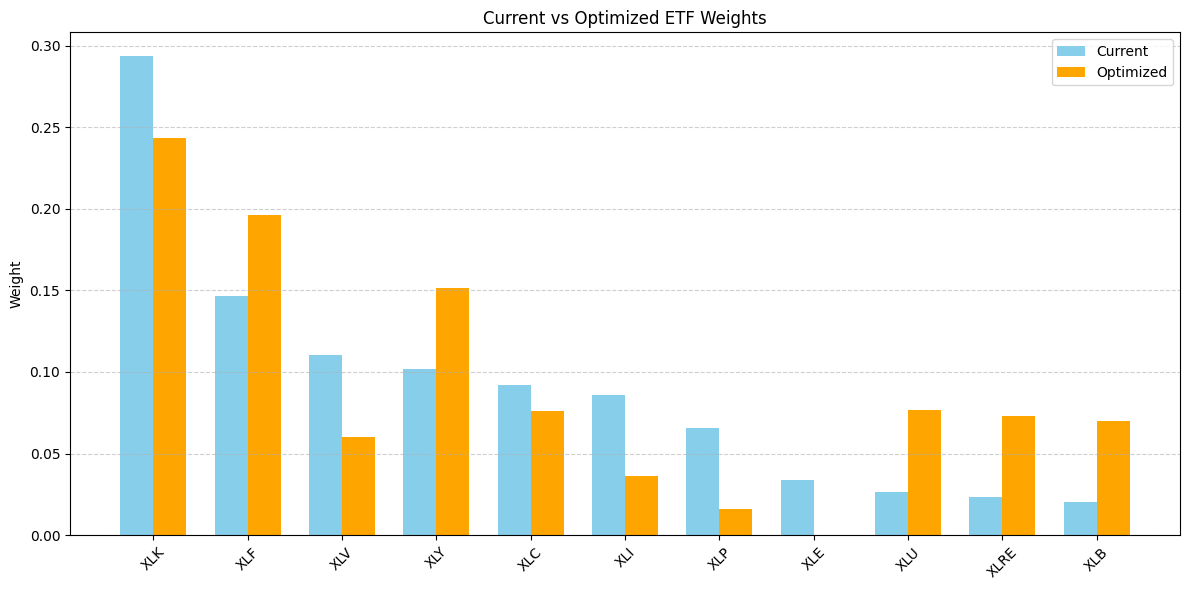

In [13]:
import matplotlib.pyplot as plt

# Plot comparison of weights
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(tickers))
width = 0.35

ax.bar(x - width/2, comparison_df['Current Weight'], width, label='Current', color='skyblue')
ax.bar(x + width/2, comparison_df['Optimized Weight'], width, label='Optimized', color='orange')

ax.set_ylabel('Weight')
ax.set_title('Current vs Optimized ETF Weights')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
